In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import PIL.Image
import imageio
import tfutil
import matplotlib.pyplot as plt
import os
import sys

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
network_path = "/om/user/shobhita/src/chexpert/CheXpert GAN/"
output_data_path = "/om/user/shobhita/src/chexpert/gan_fake_data/"
real_data_path = "/om/user/shobhita/src/chexpert/data/"

names = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

names_no_consolidation = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
       'Lung Lesion', 'Edema', 'Pneumonia', 'Atelectasis',
       'Pneumothorax', 'Pleural Effusion', 'Pleural Other', 'Fracture',
       'Support Devices']

In [34]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [35]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import pretrained Chexpert GAN.
with open(network_path + "network-final.pkl", 'rb') as file:
    G, D, Gs = pickle.load(file)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1735: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [7]:
# for name in names_no_consolidation:
#     labels[name][labels[name] == -1] = 1
# labels["Consolidation"][labels["Consolidation"] == -1] = 0
# labels = labels.fillna(0)

In [36]:
label_path = "/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/train_preprocessed_subset_10.csv"
labels = pd.read_csv(label_path)
len(labels)

20371

In [37]:
def get_class_split(labels, proportion=True):
    split = {}
    total = len(labels)
    for name in names:
        split[name] = sum(labels[name])/total if proportion else sum(labels[name])
    return split
split = get_class_split(labels)

# Generate based on percentages

In [38]:
split = get_class_split(labels, proportion=False)
total = len(labels)
low = {name: value for name, value in split.items() if value/total <= 0.09}

In [39]:
low

{'Lung Lesion': 927.0, 'Pleural Other': 603.0, 'Fracture': 887.0}

In [40]:
lesion = low['Lung Lesion']
pleural = low['Pleural Other']
fracture = low['Fracture']

In [47]:
x, y, z = int(10500), int(11500), int(10500)
new_total = total + x + y + z

print("Lesion: {}/{} + {} --> {}/{}".format(lesion, lesion/total, x, lesion+x, (lesion+x)/(total+new_total)))
print("Pleural: {}/{} + {} --> {}/{}".format(pleural, pleural/total, y, pleural+y, (pleural+y)/(total + new_total)))
print("Fracture: {}/{} + {} --> {}/{}".format(fracture, fracture/total, z, fracture+z, (fracture+z)/(total + new_total)))

Lesion: 927.0/0.045505866182318 + 10500 --> 11427.0/0.15601703940362088
Pleural: 603.0/0.029600903244808796 + 11500 --> 12103.0/0.16524671636492722
Fracture: 887.0/0.04354229051102057 + 10500 --> 11387.0/0.15547090467218264


In [48]:
label_vectors = {}
x, y, z = 10500, 11500, 10500
for cat, num_to_sample in zip(["Lung Lesion", "Pleural Other", "Fracture"], [x, y, z]):
    print("Generating {} for cat {}".format(num_to_sample, cat))
    relevant_labels = labels[labels[cat] == 1]
    new_labels = relevant_labels.sample(num_to_sample, replace=True)[names].to_numpy()
    label_vectors[cat] = new_labels

Generating 10500 for cat Lung Lesion
Generating 11500 for cat Pleural Other
Generating 10500 for cat Fracture


In [49]:
output_data_path = "/om/user/shobhita/src/chexpert/data/CheXpert-v1.0-small/train/patient65000/study1/"
output_labels_path = "/om/user/shobhita/src/chexpert/data/"
cats = ["Lung Lesion", "Pleural Other", "Fracture"]
labels_save = {}
for cat in cats:
    labels = label_vectors[cat]
    batch = 1
    used_labels = []
    used_imgname = []
    latents_raw = np.random.RandomState(1000).randn(labels.shape[0], *Gs.input_shapes[0][1:])
    total_num = latents_raw.shape[0]

    print("Generating {}".format(cat))

    for n in range(int(total_num / batch)):
        if n % 100 == 0:
            print("{}/{}".format(n, total_num))

        latent_vec = latents_raw[n * batch: (n + 1) * batch, :]
        label_vec = labels[n * batch: (n + 1) * batch, :]
        used_labels.append(label_vec)
        images = Gs.run(latent_vec, label_vec)
        images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8)  # [-1,1] => [0,255]
        images = images.transpose(0, 2, 3, 1)  # NCHW => NHWC
        save_images = np.squeeze(images, axis=-1)

        data_dir = output_data_path
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)

        for idx in range(save_images.shape[0]):
            image_idx = idx + batch * n
            labels_save["{}_{}".format(cat.replace(" ", "_"), image_idx)] = labels[image_idx, :]
            store_name = '{}_{}.jpg'.format(cat.replace(" ", "_"), image_idx)
            used_imgname.append(store_name)
            store_path = os.path.join(data_dir, store_name)
            imageio.imwrite(store_path, save_images[idx])
    
    print("Done with {}".format(cat))
    print("Num ims to generate: ", len(labels))
    print("Num labels generated: ", len(used_labels))
    print("Num ims generated: ", len(used_imgname))

with open(output_labels_path + "gan_labels_10.pkl", "wb") as handle:
    pickle.dump(labels_save, handle)

Generating Lung Lesion
0/10500
100/10500
200/10500
300/10500
400/10500
500/10500
600/10500
700/10500
800/10500
900/10500
1000/10500
1100/10500
1200/10500
1300/10500
1400/10500
1500/10500
1600/10500
1700/10500
1800/10500
1900/10500
2000/10500
2100/10500
2200/10500
2300/10500
2400/10500
2500/10500
2600/10500
2700/10500
2800/10500
2900/10500
3000/10500
3100/10500
3200/10500
3300/10500
3400/10500
3500/10500
3600/10500
3700/10500
3800/10500
3900/10500
4000/10500
4100/10500
4200/10500
4300/10500
4400/10500
4500/10500
4600/10500
4700/10500
4800/10500
4900/10500
5000/10500
5100/10500
5200/10500
5300/10500
5400/10500
5500/10500
5600/10500
5700/10500
5800/10500
5900/10500
6000/10500
6100/10500
6200/10500
6300/10500
6400/10500
6500/10500
6600/10500
6700/10500
6800/10500
6900/10500
7000/10500
7100/10500
7200/10500
7300/10500
7400/10500
7500/10500
7600/10500
7700/10500
7800/10500
7900/10500
8000/10500
8100/10500
8200/10500
8300/10500
8400/10500
8500/10500
8600/10500
8700/10500
8800/10500
8900/10500

# Generate based on a number

In [22]:
filename = "CheXpert-v1.0-small/train_preprocessed_subset_10.csv"
train_labels = pd.read_csv(real_data_path + filename)

In [24]:
cats = ["Lung Lesion", "Pleural Other", "Fracture"]
splits = get_class_split(train_labels, proportion=False)

In [33]:
max_num_samples = max(list(splits.values()))
num_to_generate = {cat: int(max_num_samples-splits[cat]) for cat in cats}

In [42]:
label_vectors = {}
for cat in cats:
    relevant_labels = train_labels[train_labels[cat] == 1]
    new_labels = relevant_labels.sample(num_to_generate[cat], replace=True)[names].to_numpy()
    label_vectors[cat] = new_labels

print(num_to_generate)
for cat, arr in label_vectors.items():
    print("{}: {}".format(cat, arr.shape))

{'Lung Lesion': 9698, 'Pleural Other': 10022, 'Fracture': 9738}
Lung Lesion: (9698, 14)
Pleural Other: (10022, 14)
Fracture: (9738, 14)


In [44]:
output_data_path = "/om/user/shobhita/src/chexpert/data/gan_data_10/"
output_labels_path = "/om/user/shobhita/src/chexpert/data/"

labels_save = {}
for cat in cats:
    labels = label_vectors[cat]
    batch = 1
    used_labels = []
    used_imgname = []
    latents_raw = np.random.RandomState(1000).randn(labels.shape[0], *Gs.input_shapes[0][1:])
    total_num = latents_raw.shape[0]

    print("Generating {}".format(cat))

    for n in range(int(total_num / batch)):
        if n % 100 == 0:
            print("{}/{}".format(n, total_num))

        latent_vec = latents_raw[n * batch: (n + 1) * batch, :]
        label_vec = labels[n * batch: (n + 1) * batch, :]
        used_labels.append(label_vec)
        images = Gs.run(latent_vec, label_vec)
        images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8)  # [-1,1] => [0,255]
        images = images.transpose(0, 2, 3, 1)  # NCHW => NHWC
        save_images = np.squeeze(images, axis=-1)

        data_dir = output_data_path
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)

        for idx in range(save_images.shape[0]):
            image_idx = idx + batch * n
            labels_save["{}_{}".format(cat.replace(" ", "_"), image_idx)] = labels[image_idx, :]
            store_name = '{}_{}.jpg'.format(cat.replace(" ", "_"), image_idx)
            used_imgname.append(store_name)
            store_path = os.path.join(data_dir, store_name)
            imageio.imwrite(store_path, save_images[idx])
    
    print("Done with {}".format(cat))
    print("Num ims to generate: ", len(labels))
    print("Num labels generated: ", len(used_labels))
    print("Num ims generated: ", len(used_imgname))

with open(output_labels_path + "gan_labels_10.pkl", "wb") as handle:
    pickle.dump(labels_save, handle)

Generating Lung Lesion
0/9698
100/9698
200/9698
300/9698
400/9698
500/9698
600/9698
700/9698
800/9698
900/9698
1000/9698
1100/9698
1200/9698
1300/9698
1400/9698
1500/9698
1600/9698
1700/9698
1800/9698
1900/9698
2000/9698
2100/9698
2200/9698
2300/9698
2400/9698
2500/9698
2600/9698
2700/9698
2800/9698
2900/9698
3000/9698
3100/9698
3200/9698
3300/9698
3400/9698
3500/9698
3600/9698
3700/9698
3800/9698
3900/9698
4000/9698
4100/9698
4200/9698
4300/9698
4400/9698
4500/9698
4600/9698
4700/9698
4800/9698
4900/9698
5000/9698
5100/9698
5200/9698
5300/9698
5400/9698
5500/9698
5600/9698
5700/9698
5800/9698
5900/9698
6000/9698
6100/9698
6200/9698
6300/9698
6400/9698
6500/9698
6600/9698
6700/9698
6800/9698
6900/9698
7000/9698
7100/9698
7200/9698
7300/9698
7400/9698
7500/9698
7600/9698
7700/9698
7800/9698
7900/9698
8000/9698
8100/9698
8200/9698
8300/9698
8400/9698
8500/9698
8600/9698
8700/9698
8800/9698
8900/9698
9000/9698
9100/9698
9200/9698
9300/9698
9400/9698
9500/9698
9600/9698
Done with Lung Lesi

NameError: name 'output_label_path' is not defined

In [46]:
with open(output_labels_path + "gan_labels_10.pkl", "wb") as handle:
    pickle.dump(labels_save, handle)

# Replicate the training set (Example)

In [22]:
# Read the labels
labels = np.load('//nas5.pmi.rwth-aachen.de/mri-scratch/DeepLearning/CheXpert_Dataset/labels/label_CheXpert.npy'
                , allow_pickle=True)
vals = labels.item().values()
values = np.array(list(vals))
labels = values
labels[:20]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0

In [20]:
# Initialize TensorFlow session.
tf.InteractiveSession()

# Import official CelebA-HQ networks.
with open('network-snapshot-012000.pkl', 'rb') as file:
    G, D, Gs = pickle.load(file)

W1204 10:55:10.065437 10724 deprecation_wrapper.py:119] From C:\Users\peter\2080Ti\Jupyter\CheXpert_256\tfutil.py:468: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1204 10:55:10.067432 10724 deprecation_wrapper.py:119] From C:\Users\peter\2080Ti\Jupyter\CheXpert_256\tfutil.py:471: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1204 10:55:10.067432 10724 deprecation_wrapper.py:119] From C:\Users\peter\2080Ti\Jupyter\CheXpert_256\tfutil.py:471: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W1204 10:55:10.068429 10724 deprecation_wrapper.py:119] From C:\Users\peter\2080Ti\Jupyter\CheXpert_256\tfutil.py:472: The name tf.get_variable_scope is deprecated. Please use tf.compat.v1.get_variable_scope instead.

W1204 10:55:10.068429 10724 deprecation_wrapper.py:119] From C:\Users\peter\2080Ti\Jupyter\CheXpert_256\tfutil.py:475: The name tf.placeholder is deprecat

In [23]:
batch = 1
used_labels = []
used_imgname = []
latents_raw = np.random.RandomState(1000).randn(labels.shape[0], *Gs.input_shapes[0][1:])
total_num = latents_raw.shape[0]
for n in range (int(total_num / batch)):
    latent_vec = latents_raw[n * batch: (n+1) * batch, :]
    label_vec = labels[n * batch: (n+1) * batch, :]
    used_labels.append(label_vec)
    images = Gs.run(latent_vec, label_vec)
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8) # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1) # NCHW => NHWC
    save_images = np.squeeze(images, axis = -1)
    
    data_dir = "//nas5.pmi.rwth-aachen.de/mri-scratch/DeepLearning/Fake_Stanford/"
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)

    for idx in range(save_images.shape[0]):
        image_idx = idx + batch * n
        store_name = 'fake_%d.png' %image_idx
        used_imgname.append(store_name)
        store_path = os.path.join(data_dir, store_name)
        imageio.imwrite(store_path, save_images[idx])

print(len(used_labels))
print(len(used_imgname))

191229
191229


In [25]:
labels[:20]
used_labels[:20]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.],
       [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0

[array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([[0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0.]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]),
 array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([[0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.]]),
 array([[0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]]),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]]),
 array([[0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [11]:
labels = np.zeros((3,14))
labels[0][3] = 1
labels[1][10] = 1
labels[2][11] = 1

In [13]:
labels

array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [28]:
labels_save = {}

batch = 1
used_labels = []
used_imgname = []
latents_raw = np.random.RandomState(1000).randn(labels.shape[0], *Gs.input_shapes[0][1:])
total_num = latents_raw.shape[0]

ims = []

for n in range(int(total_num / batch)):
    latent_vec = latents_raw[n * batch: (n + 1) * batch, :]
    label_vec = labels[n * batch: (n + 1) * batch, :]
    used_labels.append(label_vec)
    images = Gs.run(latent_vec, label_vec)
    images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8)  # [-1,1] => [0,255]
    images = images.transpose(0, 2, 3, 1)  # NCHW => NHWC
    save_images = np.squeeze(images, axis=-1)
    ims.append(save_images)

#     for idx in range(save_images.shape[0]):
#         image_idx = idx + batch * n
#         labels_save["{}_{}".format(cat, image_idx)] = labels[image_idx, :]
#         store_name = 'fake_{}_{}.png'.format(cat, image_idx)
#         used_imgname.append(store_name)
#         store_path = os.path.join(data_dir, store_name)
#         imageio.imwrite(store_path, save_images[idx])

print(len(labels))
print(len(used_labels))
print(len(used_imgname))


3
3
0


(-0.5, 255.5, 255.5, -0.5)

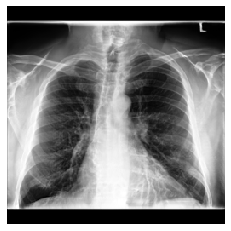

In [31]:
plt.imshow(ims[2][0], cmap="gray")
plt.axis("off")

In [30]:
tf.InteractiveSession()

# Import pretrained Chexpert GAN.
with open(network_path + "network-final.pkl", 'rb') as file:
    G, D, Gs = pickle.load(file)

real_labels = pd.read_csv(real_data_path + "CheXpert-v1.0-small/train_preprocessed.csv")

classes_to_generate = ["Lung Lesion", "Pleural Other", "Fracture"]
total = len(real_labels)

lesion =  sum(real_labels["Lung Lesion"])
pleural = sum(real_labels["Pleural Other"])
fracture = sum(real_labels["Fracture"])

lesion_n, pleural_n, fracture_n = int(lesion*1.65), int(pleural*3.65), int(fracture*1.95)
total_gen = total + lesion_n + pleural_n + fracture_n

print("Lesion: {}/{} + {} --> {}/{}".format(lesion, lesion/total, lesion_n, lesion+lesion_n, (lesion+lesion_n)/(total+total_gen)))
print("Pleural: {}/{} + {} --> {}/{}".format(pleural, pleural/total, pleural_n, pleural+pleural_n, (pleural+pleural_n)/(total + total_gen)))
print("Fracture: {}/{} + {} --> {}/{}".format(fracture, fracture/total, fracture_n, fracture+fracture_n, (fracture+fracture_n)/(total + total_gen)))
sys.stdout.flush()


label_vectors = {}
for cat, n in zip(classes_to_generate, [lesion_n, pleural_n, fracture_n]):
    relevant_labels = real_labels[real_labels[cat] == 1]
    new_labels = relevant_labels.sample(n, replace=True)[names].to_numpy()
    label_vectors[cat] = new_labels

for cat, arr in label_vectors.items():
    print("{}: {}".format(cat, arr.shape))



Lesion: 9641.0/0.04787204989299423 + 15907 --> 25548.0/0.0560384820388637
Pleural: 5542.0/0.02751860808079805 + 20228 --> 25770.0/0.056525429863062374
Fracture: 8710.0/0.04324920180147077 + 16984 --> 25694.0/0.056358727004327695
Lung Lesion: (15907, 14)
Pleural Other: (20228, 14)
Fracture: (16984, 14)


In [36]:
labels_save = {}
for cat in classes_to_generate:
    labels = label_vectors[cat]
    batch = 1
    used_labels = []
    used_imgname = []
    latents_raw = np.random.RandomState(1000).randn(labels.shape[0], *Gs.input_shapes[0][1:])
    total_num = latents_raw.shape[0]

    print("Generating {}".format(cat))
    sys.stdout.flush()

    for n in range(int(total_num / batch)):
        if n % 100 == 0:
            print("{}/{}".format(n, total_num))

        latent_vec = latents_raw[n * batch: (n + 1) * batch, :]
        label_vec = labels[n * batch: (n + 1) * batch, :]
        used_labels.append(label_vec)
        images = Gs.run(latent_vec, label_vec)
        images = np.clip(np.rint((images + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype(np.uint8)  # [-1,1] => [0,255]
        images = images.transpose(0, 2, 3, 1)  # NCHW => NHWC
        save_images = np.squeeze(images, axis=-1)

        data_dir = output_data_path
        if not os.path.exists(data_dir):
            os.makedirs(data_dir)

        for idx in range(save_images.shape[0]):
            image_idx = idx + batch * n
            labels_save["{}_{}".format(cat, image_idx)] = labels[image_idx, :]
            store_name = 'fake_{}_{}.png'.format(cat, image_idx)
            used_imgname.append(store_name)
            store_path = os.path.join(data_dir, store_name)
            imageio.imwrite(store_path, save_images[idx])
    
    print("Done with {}".format(cat))
    print(len(labels))
    print(len(used_labels))
    print(len(used_imgname))
    sys.stdout.flush()

# with open(output_data_path + "gan_image_labels.pkl", "wb") as handle:
#     pickle.dump(labels_save, handle)
# sys.stdout.flush()

Generating Lung Lesion
0/15907
100/15907
200/15907
300/15907
400/15907
500/15907
600/15907
700/15907
800/15907
900/15907
1000/15907
1100/15907
1200/15907
1300/15907
1400/15907
1500/15907
1600/15907
1700/15907
1800/15907
1900/15907
2000/15907
2100/15907
2200/15907
2300/15907
2400/15907
2500/15907
2600/15907
2700/15907
2800/15907
2900/15907
3000/15907
3100/15907
3200/15907
3300/15907
3400/15907
3500/15907
3600/15907
3700/15907
3800/15907
3900/15907
4000/15907
4100/15907
4200/15907
4300/15907
4400/15907
4500/15907
4600/15907
4700/15907
4800/15907
4900/15907
5000/15907
5100/15907
5200/15907
5300/15907
5400/15907
5500/15907
5600/15907
5700/15907
5800/15907
5900/15907
6000/15907
6100/15907
6200/15907
6300/15907
6400/15907
6500/15907
6600/15907
6700/15907
6800/15907
6900/15907
7000/15907
7100/15907
7200/15907
7300/15907
7400/15907
7500/15907
7600/15907
7700/15907
7800/15907
7900/15907
8000/15907
8100/15907
8200/15907
8300/15907
8400/15907
8500/15907
8600/15907
8700/15907
8800/15907
8900/15907

In [24]:
with open(output_data_path + "gan_image_labels.pkl", "rb") as handle:
    l = pickle.load(handle)
l

{'Lung Lesion_0': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Pleural Other_0': array([0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0.]),
 'Fracture_0': array([0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1.])}